# LSTM을 이용한 시계열 예측

## GPU 사용

- 전력과 기온 두 개의 특성 사용
- 멀티 스텝 예측
- LSTM과 성능이 거의 같은 GRU를 사용 (속도가 빠름)

# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import r2_score, mean_squared_error
matplotlib.rcParams['figure.figsize'] = (8,2)

## 전력 사용 데이터 다운로드

In [2]:
!curl -L https://bit.ly/2Fj0z2P -o energy.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0   1301      0 --:--:-- --:--:-- --:--:--  1301
100   141    0   141    0     0    400      0 --:--:-- --:--:-- --:--:--   400
100   342  100   342    0     0    541      0 --:--:-- --:--:-- --:--:--     0
100  957k  100  957k    0     0   939k      0  0:00:01  0:00:01 --:--:--  939k


In [3]:
energy = pd.read_csv('energy.csv', parse_dates=['timestamp']) 
print(energy.shape)
energy[:3]

(26304, 3)


,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000


In [4]:
energy["timestamp"].min(), energy["timestamp"].max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00'))

In [5]:
power = energy[["load","temp"]].values
power[:20]

array([[2698.        ,   32.        ],
       [2558.        ,   32.66666667],
       [2444.        ,   30.        ],
       [2402.        ,   31.        ],
       [2403.        ,   32.        ],
       [2453.        ,   31.33333333],
       [2560.        ,   30.        ],
       [2719.        ,   29.        ],
       [2916.        ,   29.        ],
       [3105.        ,   33.33333333],
       [3174.        ,   36.66666667],
       [3180.        ,   40.33333333],
       [3184.        ,   43.66666667],
       [3147.        ,   43.33333333],
       [3122.        ,   45.        ],
       [3137.        ,   44.66666667],
       [3486.        ,   43.33333333],
       [3717.        ,   41.66666667],
       [3659.        ,   41.33333333],
       [3513.        ,   41.66666667]])

- 26304개 데이터 중에 3000개만 사용하겠다
- 2000개를 훈련용, 1000개를 검증용으로 사용


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(power)
train_sc =  x_sc[:2000]
test_sc =  x_sc[2000:3000]

- 시계열 데이터를 테이블 구조로 바꾸는 함수
- n_steps_in 은 과거 몇 샘플을 사용할지를 나타내고
- n_steps_out은 예측할 먼 미래 샘플 수를 나타낸다. 2이면 2시간 후까지 예측하려는 경우임

In [7]:
def get_xy(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y) 

In [8]:
x = np.arange(10);x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

- 5개의 값을 보고 다음 두 샘플을 예측하는 예

In [9]:
X, y = get_xy(x,5,2)
X, y

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]), array([[5, 6],
        [6, 7],
        [7, 8],
        [8, 9]]))

## 다음 샘플 예측 예
- 50 개의 시계열 샘플을 X로, 다음 값을 y로 사용

In [10]:
n_steps = 50
n_steps_out = 1
X_train, y_train = get_xy(train_sc, n_steps, n_steps_out)
X_test, y_test = get_xy(test_sc, n_steps, n_steps_out)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1950, 50, 2), (1950, 1, 2), (950, 50, 2), (950, 1, 2))

In [12]:
def plot_series(series, y=None, y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "rx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "bo")
    plt.axis([0, n_steps + 1, 0, 1])

In [13]:
# 첫 번째 샘플 보기 (0:전력, 1:기온)
X_test[0, :, 1]

array([0.53680982, 0.53680982, 0.54601227, 0.54907975, 0.55214724,
       0.56134969, 0.56748466, 0.57361963, 0.57055215, 0.54907975,
       0.54601227, 0.53680982, 0.53067485, 0.53374233, 0.53067485,
       0.53067485, 0.53067485, 0.53067485, 0.53067485, 0.53067485,
       0.53067485, 0.53067485, 0.52760736, 0.52147239, 0.52453988,
       0.52453988, 0.51533742, 0.51533742, 0.51840491, 0.52453988,
       0.52760736, 0.53680982, 0.53680982, 0.53374233, 0.53374233,
       0.53067485, 0.52760736, 0.52147239, 0.51840491, 0.50306748,
       0.50613497, 0.51226994, 0.50306748, 0.48773006, 0.45398773,
       0.45092025, 0.45398773, 0.46625767, 0.46625767, 0.45705521])

In [14]:
def rmse_r2(y_test, y_pred):
  print("RMSE =", mean_squared_error(y_test, y_pred, squared=False).round(4))
  print("R-Squares =", r2_score(y_test, y_pred).round(4))

## 선형예측 모델
- 한 시간 후 예측하기

In [15]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train[:,:,0], y_train[:,:,0])

LinearRegression()

In [16]:
y_pred = lin.predict(X_test[:,:,0])
lin.score(X_test[:,:,0], y_test[:,:,0])

0.9935176271273658

In [17]:
def plot_series(series, y=None, y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "rx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "bo")
    plt.axis([0, n_steps + 1, 0, 1])

In [45]:
matplotlib.rcParams['figure.figsize'] = (8,2)

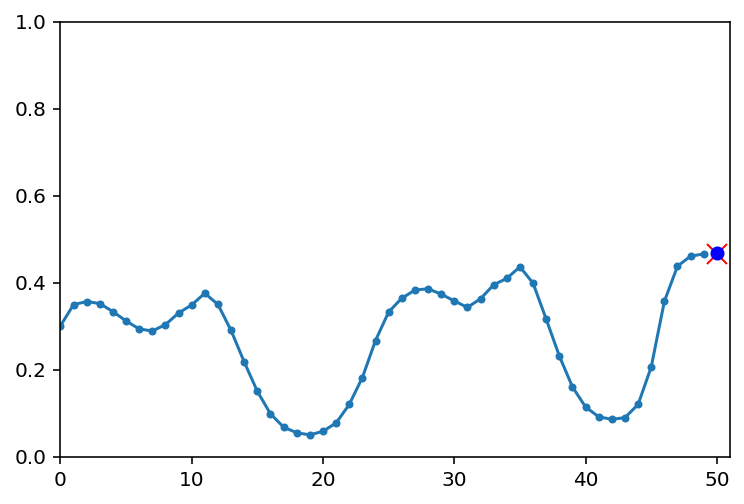

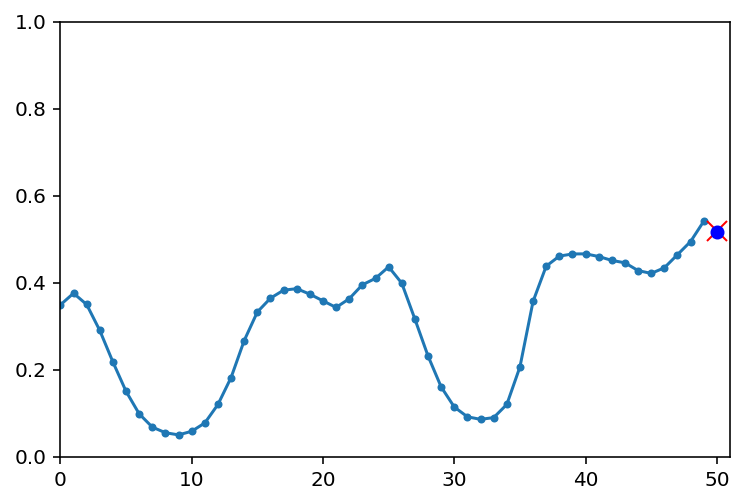

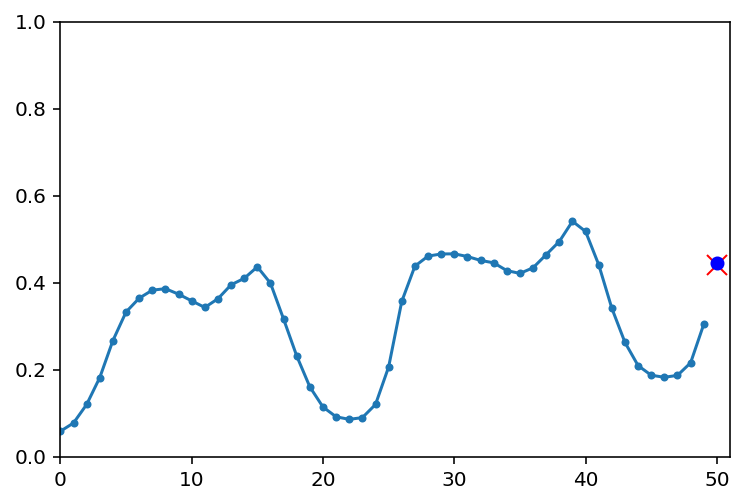

In [18]:
# 검증 시계열 데이터 확인
# 50개를 보고 다음 값을 예측하는 예를 세가지 보였다
for sample in range(0,30,10):
    plot_series(X_test[sample, :, 0], y_test[sample, :,0], y_pred[sample])
    plt.show()

## GRU를 사용하는 모델

- 목적변수는 전력량만 예측한다. 즉, 기온은 예측하지 않는다

In [19]:
import keras
import tensorflow as tf
model = keras.models.Sequential([
    keras.layers.GRU(20, input_shape=[50, 2]),
    keras.layers.Dense(1)
])
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

model.compile(loss="mse", optimizer="Adam")
history = model.fit(X_train, y_train[:,:,0], epochs=100,
                    callbacks=[cb],
                    validation_data=(X_test, y_test[:,:,0]))

Epoch 1/100
61/61 [==============================] - 5s 38ms/step - loss: 0.1479 - val_loss: 0.0411
Epoch 2/100
61/61 [==============================] - 2s 27ms/step - loss: 0.0208 - val_loss: 0.0227
Epoch 3/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 4/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0104 - val_loss: 0.0083
Epoch 5/100
61/61 [==============================] - 2s 31ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 6/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 7/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 8/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 9/100
61/61 [==============================] - 2s 27ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 10/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.0024

In [20]:
y_pred = model.predict(X_test)
rmse_r2(y_test[:,:,0], y_pred)

RMSE = 0.0196
R-Squares = 0.9777


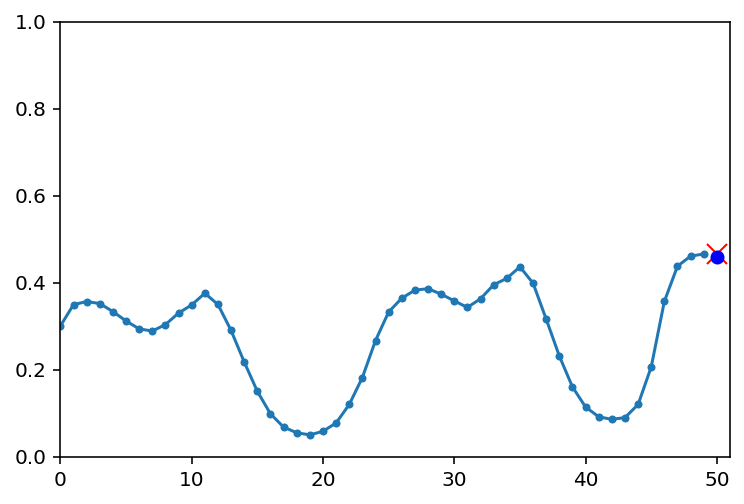

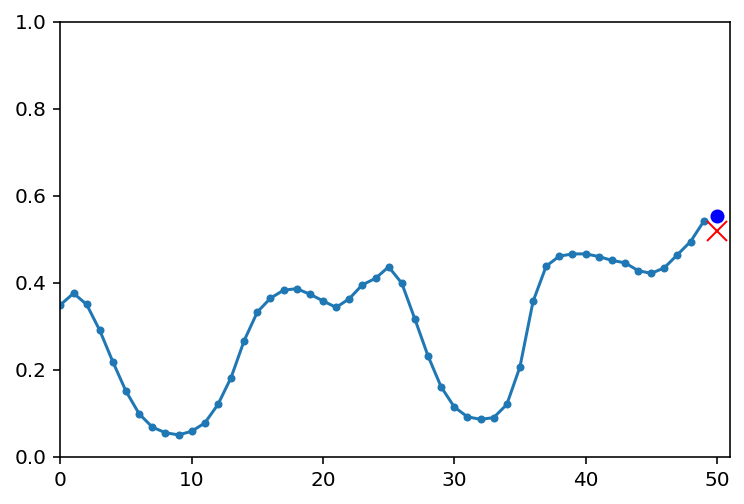

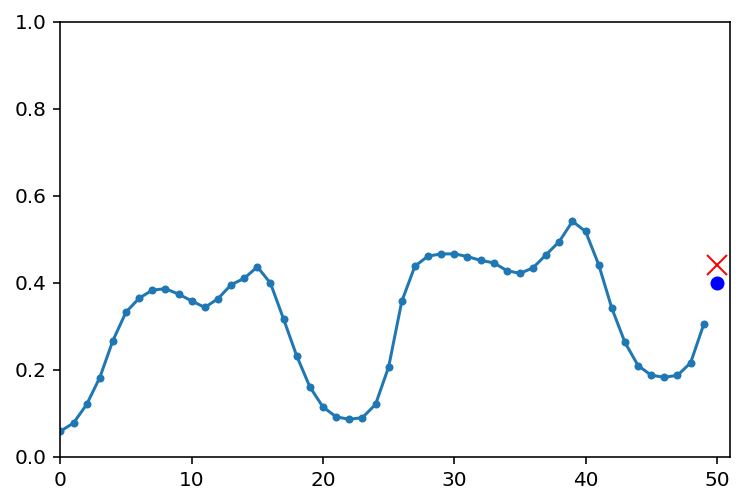

In [21]:
for sample in range(0,30,10):
    plot_series(X_test[sample, :, 0], y_test[sample, :,0], y_pred[sample])
    plt.show()

## 다층 LSTM 모델
- 회귀모델이므로 마지막 층에 Dense(1) 사용
- 직전 계층의 return_sequences=True 는 필요없다
- SimpleRNN은 활성화 함수가 tanh이다


In [22]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[50, 2]),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

model.compile(loss="mse", optimizer="Adam")
history = model.fit(X_train, y_train[:,:,0], epochs=100,
                    callbacks=[cb],
                    validation_data=(X_test, y_test[:,:,0]))

Epoch 1/100
61/61 [==============================] - 12s 117ms/step - loss: 0.0494 - val_loss: 0.0151
Epoch 2/100
61/61 [==============================] - 4s 60ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 3/100
61/61 [==============================] - 3s 57ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 4/100
61/61 [==============================] - 4s 58ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 5/100
61/61 [==============================] - 4s 66ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 6/100
61/61 [==============================] - 3s 55ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/100
61/61 [==============================] - 3s 54ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/100
61/61 [==============================] - 3s 55ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/100
61/61 [==============================] - 5s 90ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/100
61/61 [==============================] - 4s 65ms/step - loss: 0.0013 - val_loss: 0.00

In [23]:
y_pred = model.predict(X_test)
rmse_r2(y_test[:,:,0], y_pred)

RMSE = 0.0233
R-Squares = 0.9686


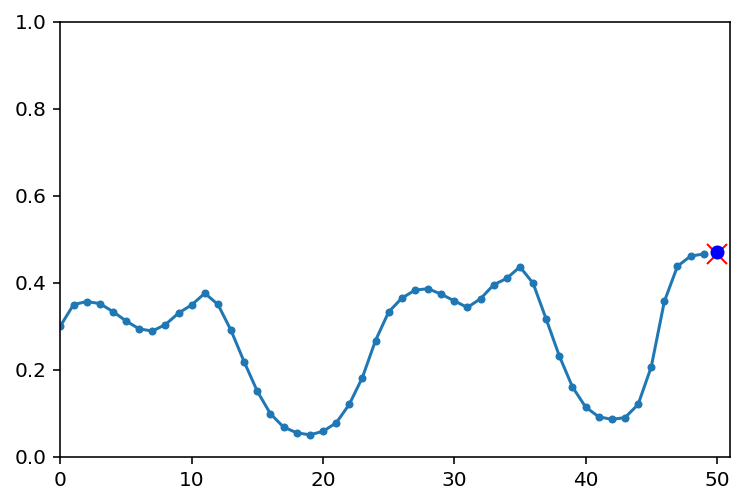

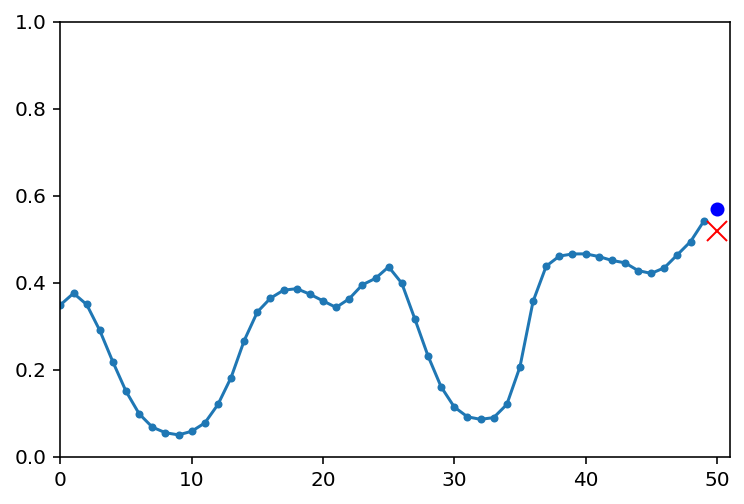

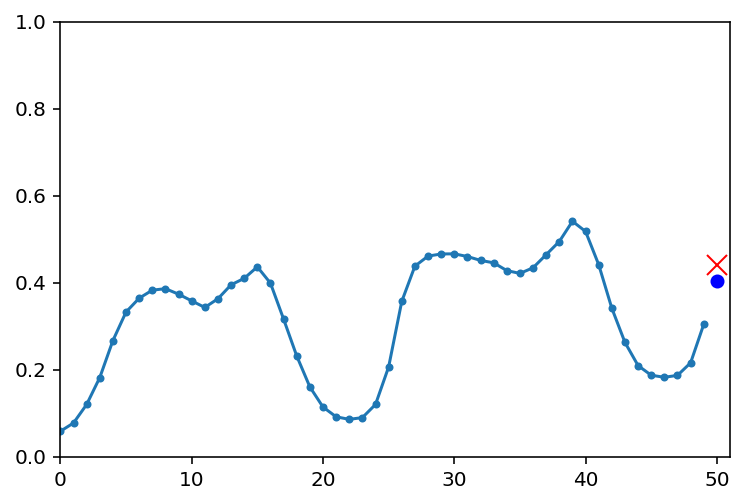

In [24]:
for sample in range(0,30,10):
    plot_series(X_test[sample, :, 0], y_test[sample, :,0], y_pred[sample])
    plt.show()

# 멀티 스텝 예측

- 과거 50개의 샘플을 보고 미래 12개의 값을 한번에 예측하는 모델 (벡터 출력 방법)

In [25]:
n_steps_in = 50
n_steps_out = 12

X_train, y_train = get_xy(train_sc, n_steps_in, n_steps_out)
X_test, y_test = get_xy(test_sc, n_steps_in, n_steps_out)

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1939, 50, 2), (1939, 12, 2), (939, 50, 2), (939, 12, 2))

In [27]:
import tensorflow as tf
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[50, 2]),
    keras.layers.GRU(20),
    keras.layers.Dense(12)
])
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

model.compile(loss="mse", optimizer="Adam")
history = model.fit(X_train, y_train[:,:,0], epochs=100,
                    callbacks=[cb],
                    validation_data=(X_test, y_test[:,:,0]))

Epoch 1/100
61/61 [==============================] - 9s 75ms/step - loss: 0.0722 - val_loss: 0.0355
Epoch 2/100
61/61 [==============================] - 4s 58ms/step - loss: 0.0256 - val_loss: 0.0272
Epoch 3/100
61/61 [==============================] - 4s 69ms/step - loss: 0.0224 - val_loss: 0.0228
Epoch 4/100
61/61 [==============================] - 3s 57ms/step - loss: 0.0198 - val_loss: 0.0190
Epoch 5/100
61/61 [==============================] - 3s 57ms/step - loss: 0.0173 - val_loss: 0.0150
Epoch 6/100
61/61 [==============================] - 3s 57ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 7/100
61/61 [==============================] - 3s 56ms/step - loss: 0.0130 - val_loss: 0.0119
Epoch 8/100
61/61 [==============================] - 6s 92ms/step - loss: 0.0109 - val_loss: 0.0091
Epoch 9/100
61/61 [==============================] - 6s 92ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 10/100
61/61 [==============================] - 4s 61ms/step - loss: 0.0063 - val_loss: 0.0063

## 멀티 예측 그래프 그리기

In [28]:
def plot_multiple_forecasts(sample, X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[sample, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[sample, :], "rx-", label="Actual",markersize=5)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[sample, :], "bo-", label="Forecast",markersize=5)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=12)

In [29]:
# 테스트 데이터 예측
y_pred = model.predict(X_test)
rmse_r2(y_test[:,:,0], y_pred)


RMSE = 0.0479
R-Squares = 0.8657


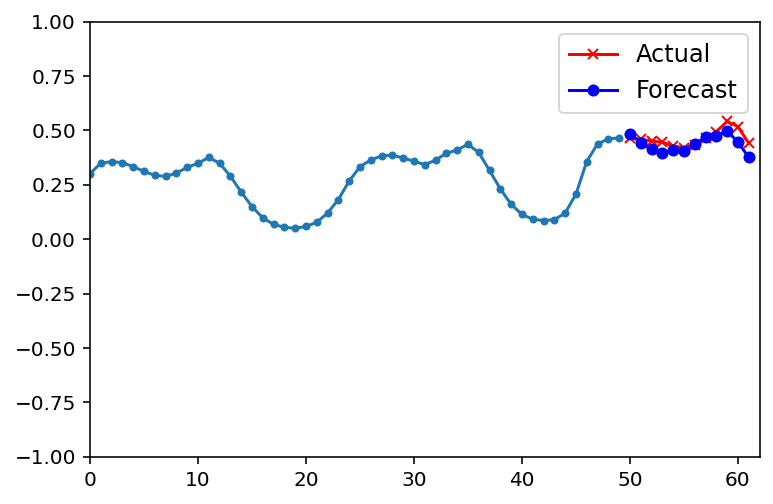

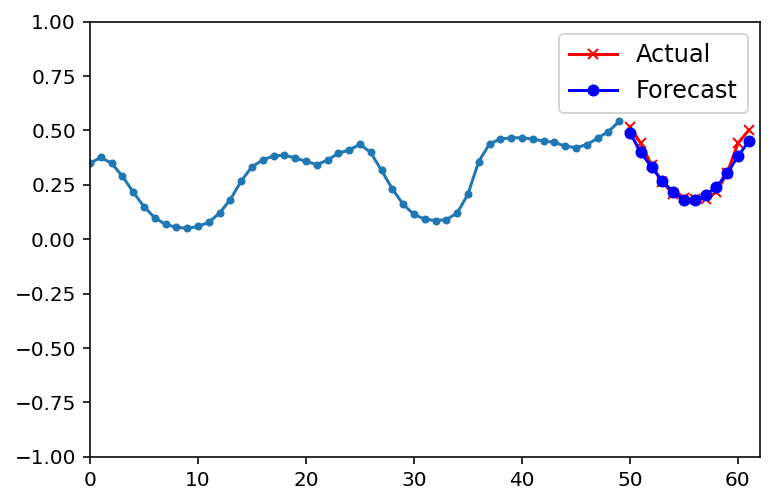

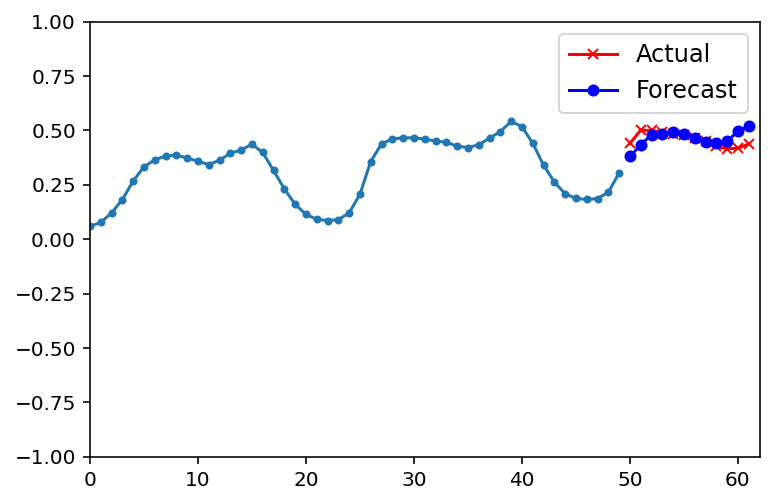

In [30]:
for sample in range(0,30,10):
  plot_multiple_forecasts(sample,X_test, y_test[:,:,0], y_pred)
  plt.show()

## 멀티스텝 예측, 랜덤 포레스트

In [31]:
X_test.shape

(939, 50, 2)

In [32]:
y_test.shape

(939, 12, 2)

In [33]:
X_train1 = X_train.reshape(-1, 100)
X_test1 = X_test.reshape(-1, 100)

In [34]:
y_test1 = y_test[:,:,0]
y_train1 = y_train[:,:,0]

In [35]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train1, y_train1)
rfr.score(X_test1, y_test1)

0.840066816547421

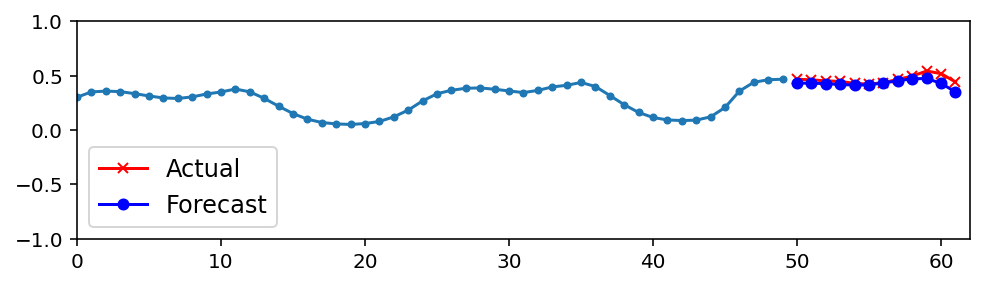

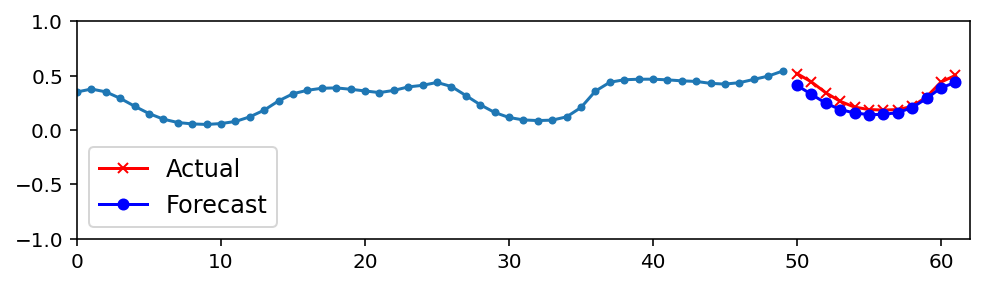

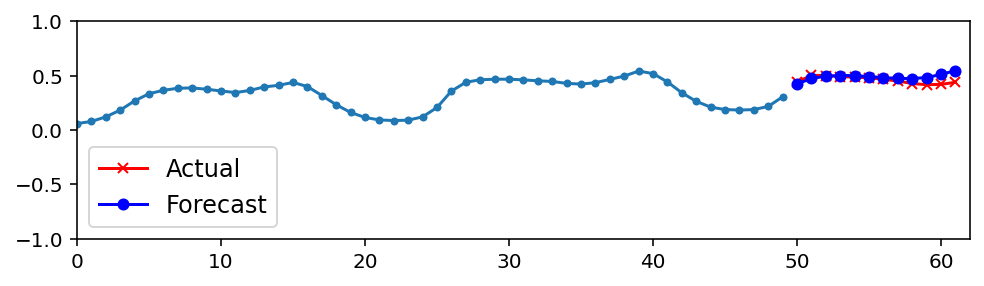

In [46]:
y_pred1 = rfr.predict(X_test1)
for sample in range(0,30,10):
  plot_multiple_forecasts(sample,X_test, y_test1, y_pred1)
  plt.show()

## 멀티스텝 예측, 선형모델을 여러번 적용하는 방법

- 1, 2, 3, .. 12 시간 후를 예측하는 선형 모델을 각각 수행한후
- r2 점수의 평균을 구한다

In [37]:
res = []
for i in range(12):
  lin.fit(X_train[:,:,0], y_train[:,i,0])
  res.append((i, lin.score(X_test[:,:,0], y_test[:,i,0])))

In [38]:
res

[(0, 0.9935061105135139),
 (1, 0.9712369383936974),
 (2, 0.9448421869894549),
 (3, 0.9238487931314667),
 (4, 0.907427963362944),
 (5, 0.8945362698488366),
 (6, 0.8840366439686987),
 (7, 0.8742547437478365),
 (8, 0.8660016594957946),
 (9, 0.8602013485692555),
 (10, 0.8562190857696105),
 (11, 0.8532763434739014)]

In [44]:
# 선형모델의 12개 예측 R2 점수
np.array(res)[:,1].mean()

0.9024490072720842